In [1]:
import yfinance as yf
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# CONFIGURACIÓN - SOLO CAMBIAR ESTOS VALORES
TICKER = "NUGT"  # Cambiar por el ticker deseado
NOMBRE_ACCION = "Coca-Cola"  # Cambiar por el nombre de la acción

In [2]:
# Descargar TODOS los datos históricos disponibles
datos_accion = yf.download(TICKER, period="max")  # Todo el histórico disponible
datos_accion = datos_accion[['Close']]
print(f"Datos históricos completos para {TICKER}:")
print(f"Desde: {datos_accion.index[0]} hasta: {datos_accion.index[-1]}")
print(f"Total de días: {len(datos_accion)}")
datos_accion.tail()  # Mostrar últimos 5 días

[*********************100%***********************]  1 of 1 completed

Datos históricos completos para NUGT:
Desde: 2010-12-08 00:00:00 hasta: 2025-09-29 00:00:00
Total de días: 3724


Price,Close
Ticker,NUGT
Date,
2025-09-23,146.350006
2025-09-24,138.850006
2025-09-25,141.600006
2025-09-26,147.669998
2025-09-29,151.929993


Determina mediante la gráfica de Auto-Correlación Parcial y los estadísticos de Akaike y Bayesiano cuál sería el modelo auto-regresivo más adecuado para ajustar dicha serie de datos. Justifica claramente su respuesta mediante una base de entrenamiento del 70% de los datos. 

In [3]:
# Usar TODOS los datos para entrenar (más realista)
datos_accion.index = pd.to_datetime(datos_accion.index)
train = datos_accion['Close']  # TODO el histórico

print(f"Datos de entrenamiento:")
print(f"Período: {train.index[0]} a {train.index[-1]}")
print(f"Total de observaciones: {len(train)}")

Datos de entrenamiento:
Período: 2010-12-08 00:00:00 a 2025-09-29 00:00:00
Total de observaciones: 3724


In [4]:
# Análisis de Auto-Correlación (ACF) y Auto-Correlación Parcial (PACF)
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import numpy as np

ACF values (primeros 10):
 [1.         0.99693674 0.99374824 0.9906568  0.98757628 0.98444732
 0.98147219 0.97860115 0.9757282  0.972733  ]


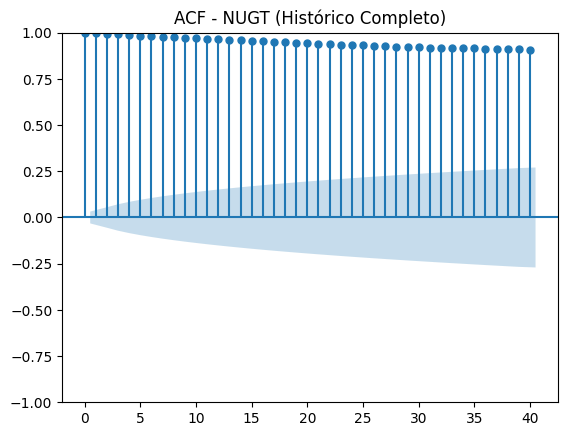

In [5]:
# Grafica de ACF con todos los datos históricos
acf_array = acf(train)
print("ACF values (primeros 10):\n", acf_array[:10])

plot_acf(train, lags=40, alpha=0.05)  # Más lags porque hay más datos
plt.title(f"ACF - {TICKER} (Histórico Completo)")
plt.show()

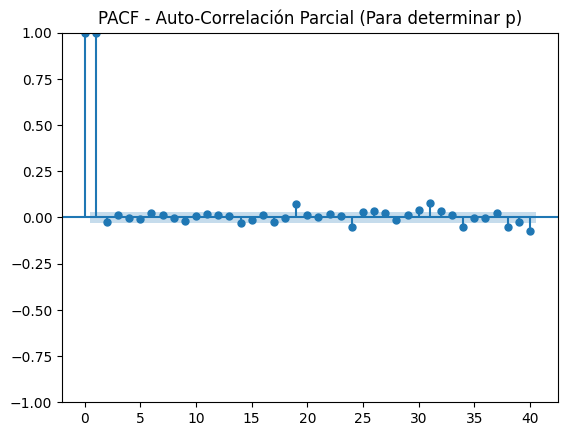

In [6]:
# Grafica PACF (Auto correlacion parcial) 
plot_pacf(train, lags=40, alpha=0.05)  # Más lags
plt.title("PACF - Auto-Correlación Parcial (Para determinar p)")
plt.show()

In [7]:
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")

max_p = 7
AIC_values = np.zeros(max_p)
BIC_values = np.zeros(max_p)

for p in range(max_p):
    model = ARIMA(train, order=(p, 0, 0))  # AR(p)
    fitted_model = model.fit()
    AIC_values[p] = fitted_model.aic
    BIC_values[p] = fitted_model.bic

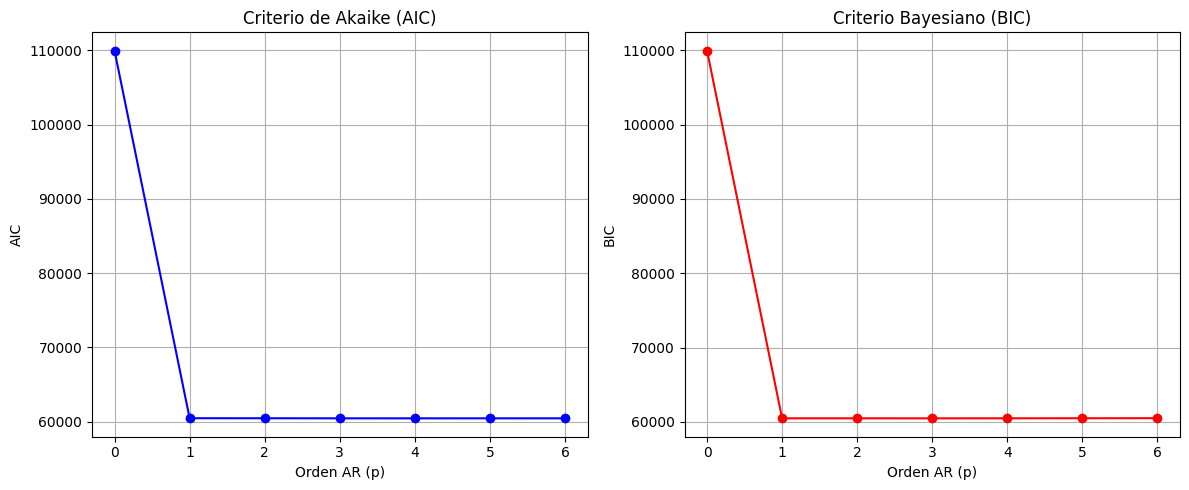

In [8]:
# Graficar AIC y BIC

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(0, max_p), AIC_values, marker='o', color='blue')
plt.title('Criterio de Akaike (AIC)')
plt.xlabel('Orden AR (p)')
plt.ylabel('AIC')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(0, max_p), BIC_values, marker='o', color='red')
plt.title('Criterio Bayesiano (BIC)')
plt.xlabel('Orden AR (p)')
plt.ylabel('BIC')
plt.grid(True)

plt.tight_layout()
plt.show()

In [9]:
best_p_aic = np.argmin(AIC_values)
best_p_bic = np.argmin(BIC_values)

print(f"Mejor p según AIC es {best_p_aic} con un AIC de {AIC_values[best_p_aic]:.2f}")
print(f"Mejor p según BIC es {best_p_bic} con un BIC de {BIC_values[best_p_bic]:.2f}")

Mejor p según AIC es 4 con un AIC de 60448.49
Mejor p según BIC es 3 con un BIC de 60480.61


In [10]:
# Entrenar modelo con TODOS los datos históricos
modelo_final = ARIMA(train, order=(best_p_aic, 0, 0))
modelo_ajustado = modelo_final.fit()

print("=== RESUMEN DEL MODELO (Entrenado con histórico completo) ===")
print(modelo_ajustado.summary())

=== RESUMEN DEL MODELO (Entrenado con histórico completo) ===
                               SARIMAX Results                                
Dep. Variable:                   NUGT   No. Observations:                 3724
Model:                 ARIMA(4, 0, 0)   Log Likelihood              -30218.246
Date:                Mon, 29 Sep 2025   AIC                          60448.491
Time:                        21:06:45   BIC                          60485.827
Sample:                             0   HQIC                         60461.774
                               - 3724                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       6755.6030   2.86e-10   2.37e+13      0.000    6755.603    6755.603
ar.L1          1.0400      0.005    193.616      0.000       1.029   

In [11]:
# Predecir próximos 10 días hábiles
from datetime import datetime, timedelta

# Obtener la última fecha de los datos
ultima_fecha = train.index[-1]
print(f"Última fecha con datos: {ultima_fecha}")

# Generar próximos 10 días hábiles
num_dias_prediccion = 10
fechas_prediccion = pd.date_range(start=ultima_fecha + timedelta(days=1), 
                                 periods=num_dias_prediccion + 5, 
                                 freq='B')[:num_dias_prediccion]

print(f"Predicción para los próximos {num_dias_prediccion} días hábiles:")
print(f"Desde: {fechas_prediccion[0]} hasta: {fechas_prediccion[-1]}")

Última fecha con datos: 2025-09-29 00:00:00
Predicción para los próximos 10 días hábiles:
Desde: 2025-09-30 00:00:00 hasta: 2025-10-13 00:00:00


In [12]:
# Generar predicciones para los próximos 10 días
predicciones_futuro = modelo_ajustado.forecast(steps=num_dias_prediccion)

# Generar intervalos de confianza del 90%
forecast_result = modelo_ajustado.get_forecast(steps=num_dias_prediccion)
conf_int_90 = forecast_result.conf_int(alpha=0.10) 

print("=== PREDICCIONES PRÓXIMOS 10 DÍAS HÁBILES ===")
print("Predicciones puntuales:")
print(predicciones_futuro)
print("\nIntervalos de confianza 90%:")
print(conf_int_90)

=== PREDICCIONES PRÓXIMOS 10 DÍAS HÁBILES ===
Predicciones puntuales:
3724    153.439051
3725    154.844668
3726    156.452617
3727    158.152444
3728    159.847036
3729    161.530018
3730    163.209763
3731    164.889736
3732    166.569784
3733    168.249467
Name: predicted_mean, dtype: float64

Intervalos de confianza 90%:
       lower NUGT   upper NUGT
3724 -1173.376092  1480.254194
3725 -1759.434461  2069.123797
3726 -2161.295747  2474.200982
3727 -2481.210317  2797.515205
3728 -2766.209004  3085.903077
3729 -3027.222058  3350.282093
3730 -3268.577264  3594.996791
3731 -3493.633139  3823.412612
3732 -3705.257440  4038.397008
3733 -3905.617757  4242.116691


In [13]:
# Crear DataFrame con resultados organizados
resultados_prediccion = pd.DataFrame({
    'Fecha': fechas_prediccion,
    'Predicción': predicciones_futuro.values,
    'Límite_Inferior_90%': conf_int_90.iloc[:, 0].values,
    'Límite_Superior_90%': conf_int_90.iloc[:, 1].values
})

resultados_prediccion = resultados_prediccion.set_index('Fecha')
print(f"Pronóstico para {TICKER} - Próximos 10 días hábiles")
print(resultados_prediccion)

Pronóstico para NUGT - Próximos 10 días hábiles
            Predicción  Límite_Inferior_90%  Límite_Superior_90%
Fecha                                                           
2025-09-30  153.439051         -1173.376092          1480.254194
2025-10-01  154.844668         -1759.434461          2069.123797
2025-10-02  156.452617         -2161.295747          2474.200982
2025-10-03  158.152444         -2481.210317          2797.515205
2025-10-06  159.847036         -2766.209004          3085.903077
2025-10-07  161.530018         -3027.222058          3350.282093
2025-10-08  163.209763         -3268.577264          3594.996791
2025-10-09  164.889736         -3493.633139          3823.412612
2025-10-10  166.569784         -3705.257440          4038.397008
2025-10-13  168.249467         -3905.617757          4242.116691


Responde ¿Qué tan exactos cree usted que serán sus predicciones? Justifique mediante el uso de indicadores de bondad de ajuste. 

In [14]:
# Análisis de bondad de ajuste con datos históricos
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

predicciones_historicas = modelo_ajustado.fittedvalues
valores_reales = train.values
pred_values = predicciones_historicas.values

print("--- INDICADORES DE BONDAD DE AJUSTE (HISTÓRICO COMPLETO) ---\n")

# CORREGIR: Alinear ambos arrays al mismo tamaño
# fittedvalues empieza desde el índice 1, así que ajustamos valores_reales
valores_alineados = valores_reales[len(valores_reales) - len(pred_values):]

mse = mean_squared_error(valores_alineados, pred_values)
mae = mean_absolute_error(valores_alineados, pred_values)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((valores_alineados - pred_values) / valores_alineados)) * 100

print(f" MSE: {mse:.2f}")
print(f" MAE: ${mae:.2f}")
print(f" RMSE: {rmse:.2f}")
print(f" MAPE: {mape:.2f}%")
print(f"\nPrecisión del modelo: {100-mape:.2f}%")

# Debug: Verificar tamaños
print(f"\nDebug - Tamaños:")
print(f"Valores reales originales: {len(valores_reales)}")
print(f"Predicciones históricas: {len(pred_values)}")
print(f"Valores reales alineados: {len(valores_alineados)}")

--- INDICADORES DE BONDAD DE AJUSTE (HISTÓRICO COMPLETO) ---

 MSE: 1714404.41
 MAE: $269.53
 RMSE: 1309.35
 MAPE: 7477.70%

Precisión del modelo: -7377.70%

Debug - Tamaños:
Valores reales originales: 3724
Predicciones históricas: 3724
Valores reales alineados: 3724


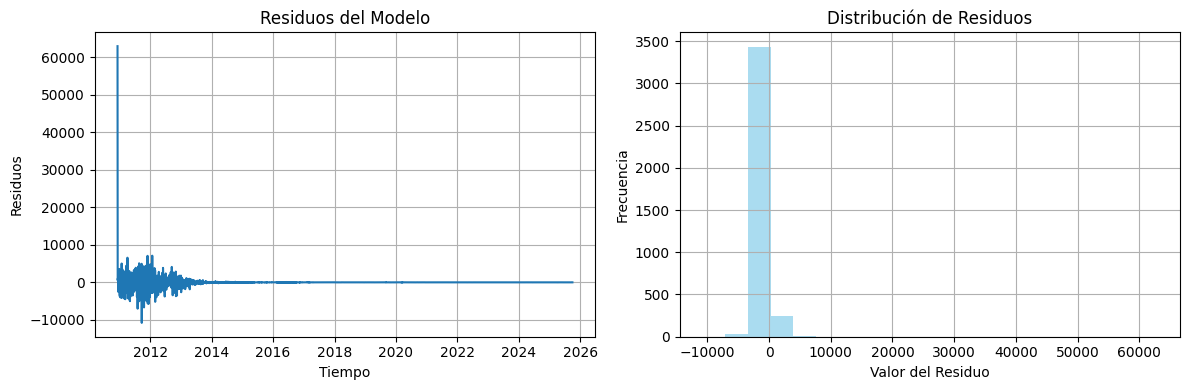

Media de residuos: -2.606200
Desviación estándar: 1309.3501


In [15]:
# Análisis de residuos del modelo
residuos = modelo_ajustado.resid

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(residuos)
plt.title('Residuos del Modelo')
plt.xlabel('Tiempo')
plt.ylabel('Residuos')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.hist(residuos, bins=20, alpha=0.7, color='skyblue')
plt.title('Distribución de Residuos')
plt.xlabel('Valor del Residuo')
plt.ylabel('Frecuencia')
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"Media de residuos: {np.mean(residuos):.6f}")
print(f"Desviación estándar: {np.std(residuos):.4f}")

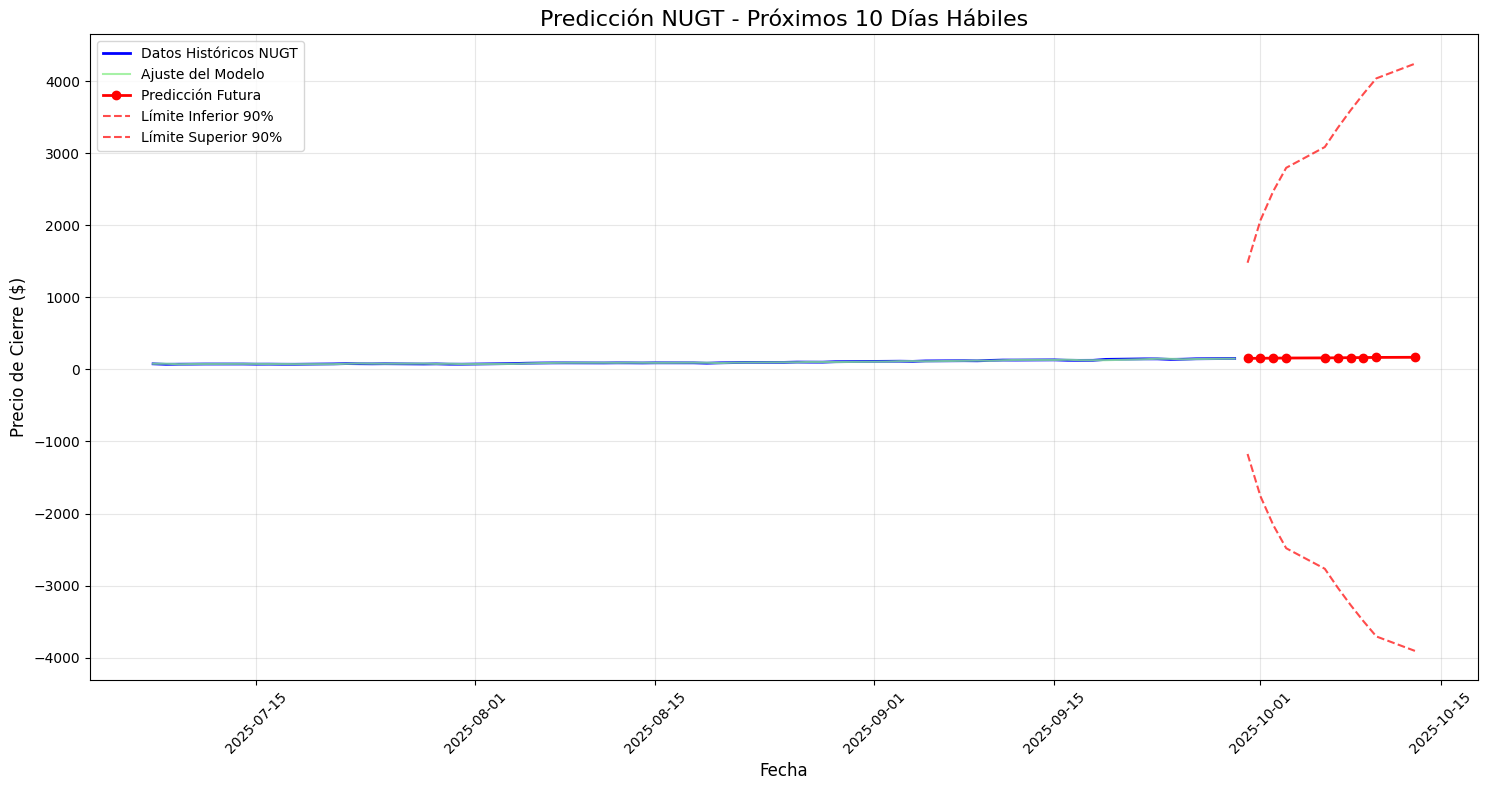


📊 RESUMEN DE PREDICCIÓN:
Precio actual: $151.93
Precio promedio predicho (10 días): $160.72
Cambio esperado: +5.78%
🟢 Tendencia esperada: ALCISTA


In [16]:
# Graficar histórico + predicción futura
plt.figure(figsize=(15, 8))

# Datos históricos (últimos 60 días para mejor visualización)
datos_recientes = train.tail(60)
plt.plot(datos_recientes.index, datos_recientes.values, 
         label=f'Datos Históricos {TICKER}', color='blue', linewidth=2)

# Predicciones ajustadas (últimos 60 días)
pred_recientes = predicciones_historicas.tail(60)
plt.plot(pred_recientes.index, pred_recientes.values, 
         label='Ajuste del Modelo', color='lightgreen', alpha=0.8)

# Predicciones futuras
plt.plot(fechas_prediccion, predicciones_futuro.values, 
         label='Predicción Futura', color='red', linewidth=2, marker='o')

# Intervalos de confianza futuros
plt.plot(fechas_prediccion, conf_int_90.iloc[:, 0].values, 
         label='Límite Inferior 90%', color='red', linestyle='--', alpha=0.7)
plt.plot(fechas_prediccion, conf_int_90.iloc[:, 1].values, 
         label='Límite Superior 90%', color='red', linestyle='--', alpha=0.7)

plt.title(f'Predicción {TICKER} - Próximos 10 Días Hábiles', fontsize=16)
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre ($)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Estadísticas de la predicción
precio_actual = float(train.iloc[-1])
precio_promedio_predicho = float(predicciones_futuro.mean())
cambio_esperado = ((precio_promedio_predicho - precio_actual) / precio_actual) * 100

print(f"\n📊 RESUMEN DE PREDICCIÓN:")
print(f"Precio actual: ${precio_actual:.2f}")
print(f"Precio promedio predicho (10 días): ${precio_promedio_predicho:.2f}")
print(f"Cambio esperado: {cambio_esperado:+.2f}%")
if cambio_esperado > 0:
    print("🟢 Tendencia esperada: ALCISTA")
else:
    print("🔴 Tendencia esperada: BAJISTA")

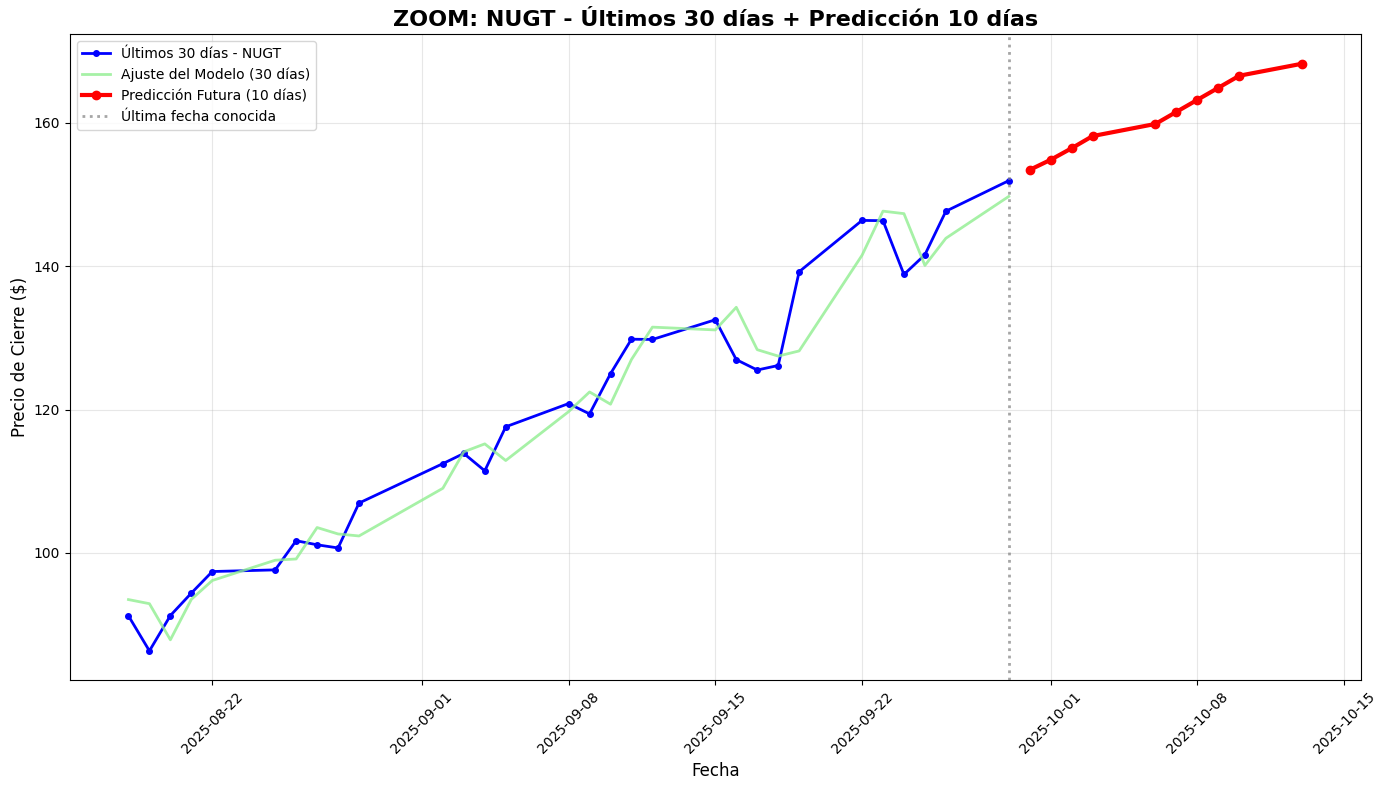


📊 RESUMEN DE PREDICCIÓN:
Precio actual: $151.93
Precio promedio predicho (10 días): $160.72
Cambio esperado: +5.78%
🟢 Tendencia esperada: ALCISTA


In [17]:
# Gráfica LIMPIA sin intervalos de confianza
plt.figure(figsize=(14, 8))

# Datos históricos (últimos 30 días)
datos_zoom = train.tail(30)
plt.plot(datos_zoom.index, datos_zoom.values, 
         label=f'Últimos 30 días - {TICKER}', color='blue', linewidth=2, marker='o', markersize=4)

# Predicciones ajustadas (últimos 30 días)
pred_zoom = predicciones_historicas.tail(30)
plt.plot(pred_zoom.index, pred_zoom.values, 
         label='Ajuste del Modelo (30 días)', color='lightgreen', alpha=0.8, linewidth=2)

# Predicciones futuras
plt.plot(fechas_prediccion, predicciones_futuro.values, 
         label='Predicción Futura (10 días)', color='red', linewidth=3, marker='o', markersize=6)

# QUITAR las líneas de intervalos de confianza

# Línea vertical para separar histórico de predicción
plt.axvline(x=datos_zoom.index[-1], color='gray', linestyle=':', alpha=0.7, linewidth=2, label='Última fecha conocida')

plt.title(f'ZOOM: {TICKER} - Últimos 30 días + Predicción 10 días', fontsize=16, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Precio de Cierre ($)', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(f"\n📊 RESUMEN DE PREDICCIÓN:")
print(f"Precio actual: ${precio_actual:.2f}")
print(f"Precio promedio predicho (10 días): ${precio_promedio_predicho:.2f}")
print(f"Cambio esperado: {cambio_esperado:+.2f}%")
if cambio_esperado > 0:
    print("🟢 Tendencia esperada: ALCISTA")
else:
    print("🔴 Tendencia esperada: BAJISTA")